# load and visualize models


In [8]:
import torch
from torch.utils import data
import vae
from glob import glob
import numpy as np
import pandas as pd
import time
from vae import PD2_LABEL_COLUMNS, PARTITION_PATH
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
import rqpy as rp
import seaborn as sns


In [9]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


Define Paths

In [10]:
basepath = '/gpfs/slac/staas/fs1/supercdms/tf/slac/Run44/'
file_mapping = '/gpfs/slac/staas/fs1/supercdms/tf/slac/Run44/Run44_v6/file_mapping.h5'
figsavepath_base = '/home/calebf/notebooks/working_dir/PD2_vae/Figs/model_testing/'
#model_folder = 'v6_8_flat'  
model_folder = 'v6_8_flat_beta1'  
#model_folder = 'v6_8_flat_beta10'  
#model_folder = 'v6_8_flat_beta100'  
#model_folder = 'v6_8_flat_beta1e-1' 
#model_folder = 'v6_8_flat_beta1e-2'  
#model_folder = 'v6_8_flat_beta5'  
#model_folder = 'v6_8_flat_beta50'
figsavepath = f'{figsavepath_base}{model_folder}/'

savefigs = True 

Load partition

In [11]:
partition = vae.io.load_partition(PARTITION_PATH, 'good_triggers_flat')


Define params

In [12]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 12, 
          'pin_memory' : False,
          'drop_last' : False}


tracelength = 1625
scale_factor = 4e-6
offset = 0.2
z_dim = 2 


Load saved model

In [13]:
model_path =sorted(glob(f'{basepath}/models/{model_folder}/*'))[-1]
epochs = int(model_path[-5:-3])
model = vae.VAE(z_dim).to(device)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])

ValueError: invalid literal for int() with base 10: 'h9'

Plot loss function

In [ ]:
if len(checkpoint['loss_val']) > 0:
    vae.plot_loss(training_loss=checkpoint['loss_train'], 
                  test_loss=checkpoint['loss_val'], 
                  nper_epoch=len(partition['validation'])/params['batch_size'], 
                  nepochs=epochs, savefig=savefigs, filename=figsavepath+'loss')
else:
    vae.plot_loss(training_loss=checkpoint['loss_train'], savefig=savefigs, filename=figsavepath+'loss')

Load data

In [ ]:
# Generators
training_set = vae.PD2dataset(partition['train'], 
                              labels='full',
                              map_path=file_mapping,
                              max_normed=False,
                              baseline_sub=True, 
                              offset=offset,
                              scaledata=scale_factor,
                              tracelength=tracelength)
train_loader = data.DataLoader(training_set, **params)

test_set = vae.PD2dataset(partition['validation'], 
                          labels='full', 
                          map_path=file_mapping,
                          max_normed=False, 
                          baseline_sub=True, 
                          offset=offset,
                          scaledata=scale_factor,
                          tracelength=tracelength)
test_loader = data.DataLoader(test_set, **params)

Plot a few reconstructed traces

In [ ]:
vae.plot_recon(test_loader, model, 10, xlims=[100,500], savefig=savefigs, filename=figsavepath+'recon')

Load latent variables

In [ ]:
arr, labels = vae.io.get_latent_vars(train_loader, model, label_rtn=True)

Reduce data with PCA and tSNE

In [ ]:
x_pca = vae.utils.reduce_dims(arr, method='PCA')

In [ ]:
x_tsne = vae.utils.reduce_dims(arr, method='tSNE')

In [ ]:
ind = PD2_LABEL_COLUMNS.index('energy')
ind

Visualize latent variables with PCA

In [ ]:
vae.plot_latent_2d(x_pca, labels[:,ind]*1e-3, label_name='Energy [keV]', 
                   pltkwargs={'alpha' : .75, 's' : 5, 'cmap' : 'icefire',  'vmin' : 0, 'vmax' : 7}
                  , savefig=savefigs, filename=figsavepath+'Latent_PCA')


Visualize latent variables with tSNE

In [7]:
vae.plot_latent_2d(x_tsne, labels[:,ind]*1e-3, label_name='Energy [keV]', 
                   pltkwargs={'alpha' : .75, 's' : 5,  'vmin' : 0, 'vmax' : 7}
                  , savefig=savefigs, filename=figsavepath+'Latent_tSNE')


NameError: name 'x_tsne' is not defined

Plot each latent variable vs True Energy

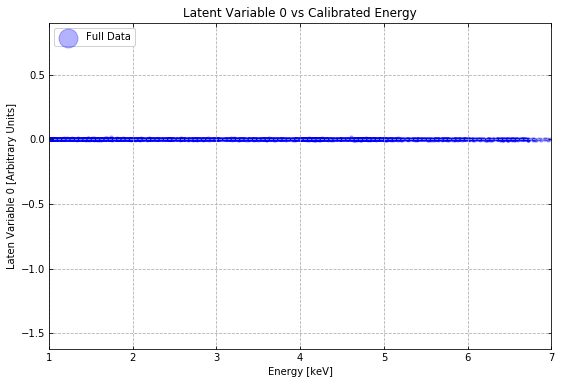

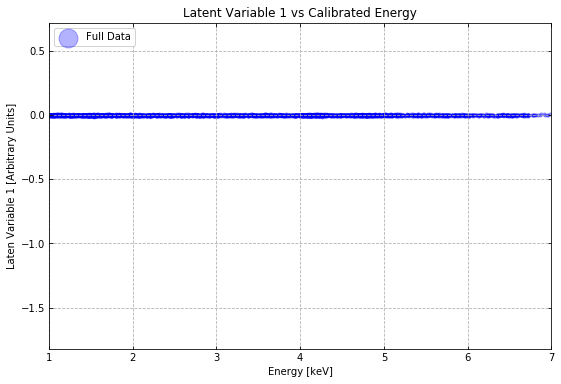

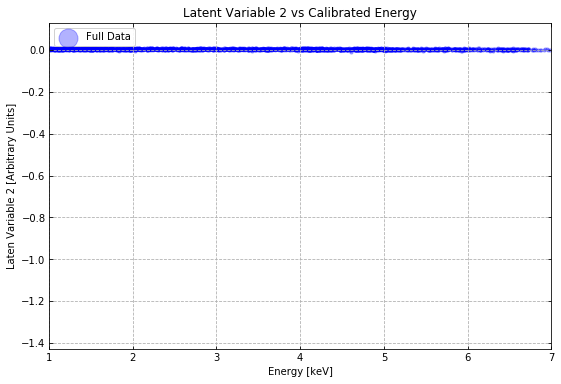

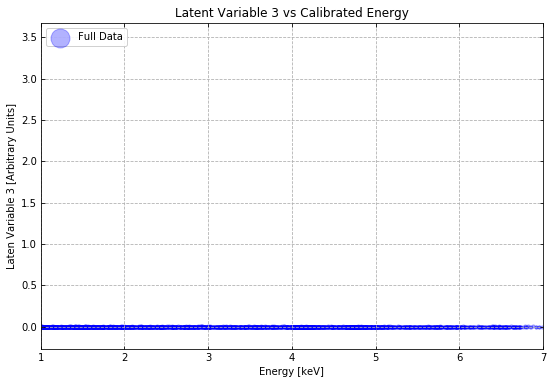

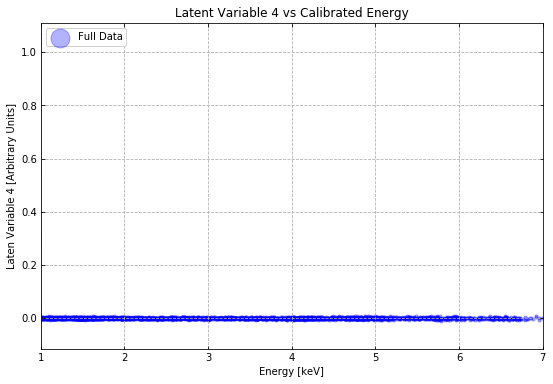

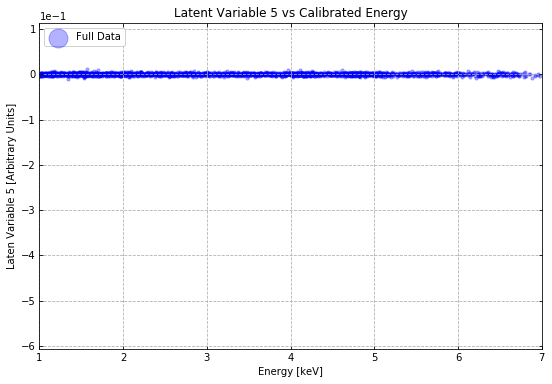

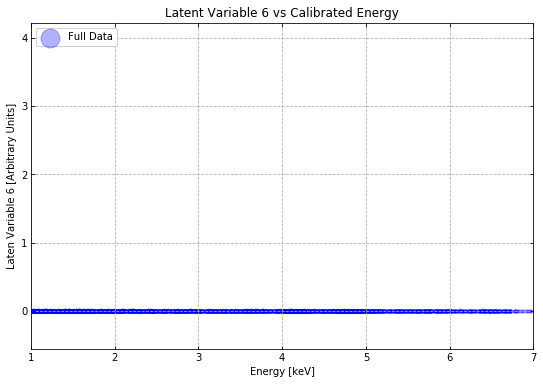

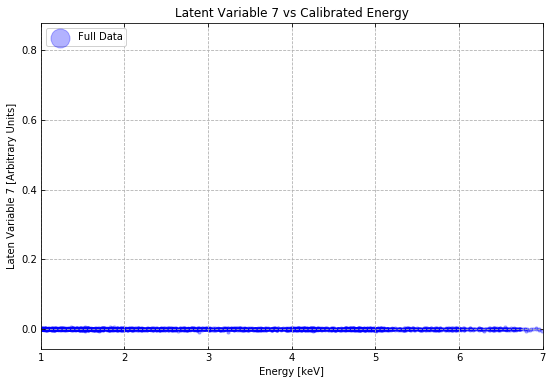

In [16]:
for ii in range(arr.shape[-1]):
    rp.scatter(labels[:, ind]*1e-3, arr[:,ii], xlims=(1, 7), ms=10)
    plt.xlabel('Energy [keV]')
    plt.ylabel(f'Laten Variable {ii} [Arbitrary Units]')
    plt.title(f'Latent Variable {ii} vs Calibrated Energy')
    if savefigs:
        plt.savefig(f'{figsavepath}Latent{ii}_vs_energy.png', dpi=400)


Make Pair plot of Laten Variables

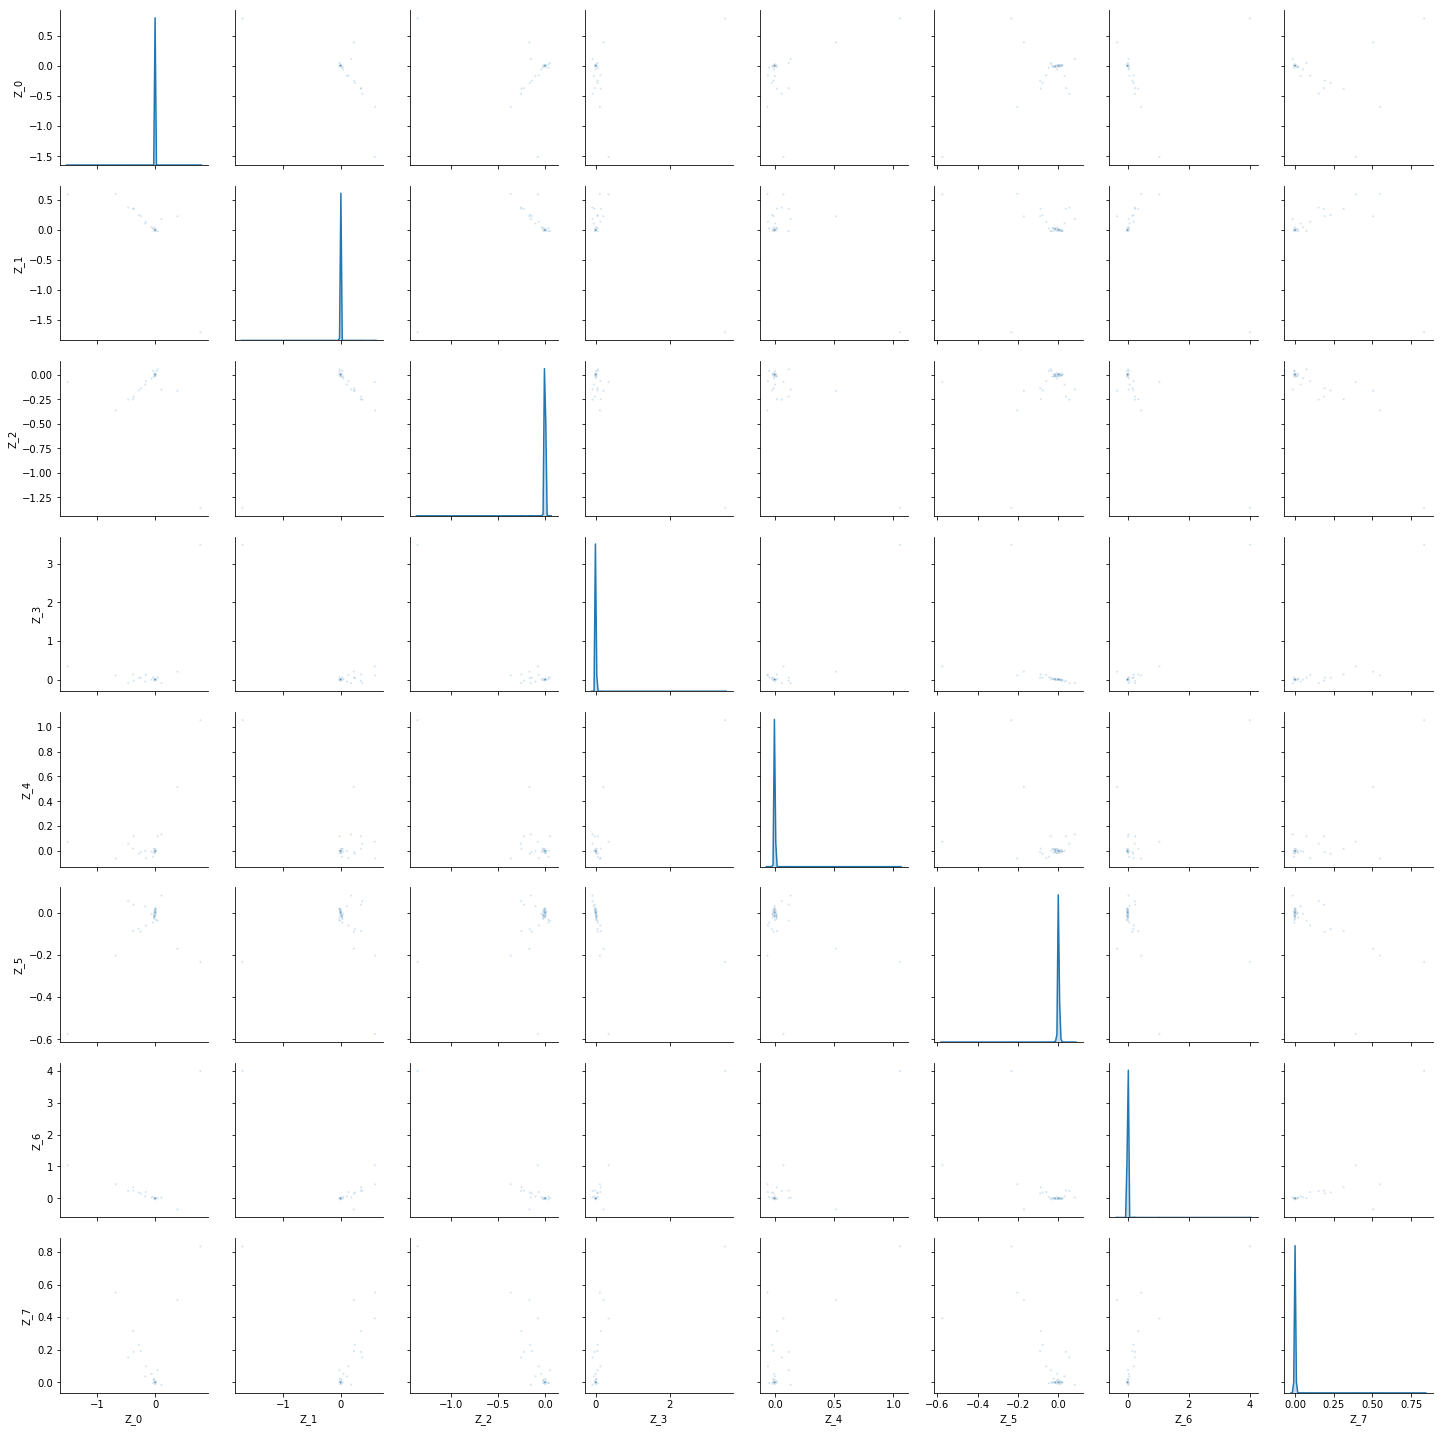

In [17]:
df = pd.DataFrame(arr, columns=[f'Z_{ii}' for ii in range(arr.shape[-1])])
sns.pairplot(df, diag_kind='kde', markers='.', plot_kws={'alpha' : .2, 'size' : 5})
if savefigs:
    plt.savefig(f'{figsavepath}latent_pairplot.png', dpi=300)